# 1. 多尺度目标检测实现

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

img = d2l.plt.imread('01_Data/03_catdog.jpg')
h, w = img.shape[:2]
print(h, w)
print(img.shape) # 最后一个元素为通道数，通道数为3

561 728
(561, 728, 3)


In [2]:
# 在特征图(fmap)上生成锚框(anchors)，每个单位(像素)作为锚框的中心
def display_anchors(fmap_w,fmap_h,s):
    d2l.set_figsize()
    fmap = torch.zeros((1,10,fmap_h,fmap_w)) # 批量大小为1，通道数为10
    anchors = d2l.multibox_prior(fmap,sizes=s,ratios=[1,2,0.5]) # 生成以每个像素为中心的锚框  
    bbox_scale = torch.tensor((w,h,w,h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes,anchors[0] * bbox_scale) # anchors[0]是因为这里的batchsize为1   

D:\11_Anaconda\envs\py3.6.3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


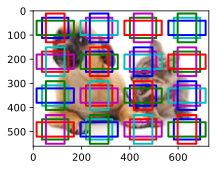

In [3]:
# 探测小目标
display_anchors(fmap_w=4,fmap_h=4,s=[0.15])

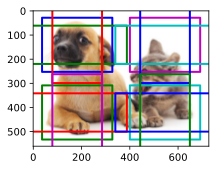

In [4]:
# 将特征图的高度和宽度减小一半，然后使用较大的锚框来检测较大的目标
display_anchors(fmap_w=2,fmap_h=2,s=[0.4])

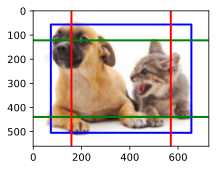

In [5]:
# 将特征图的高度和宽度较小一半，然后将锚框的尺度增加到0.8
display_anchors(fmap_w=1,fmap_h=1,s=[0.8])

# 2. 单发多框检测(SSD)

In [6]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [7]:
# 类别预测层
def cls_predictor(num_inputs, num_anchors, num_classes): # 输入通道数、多少个锚框、多少个类
    # 每个锚框的输出通道数都为(num_classes + 1),加1为加的背景类
    # 每一个锚框都要预测他的类别
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                    kernel_size=3, padding=1)

In [8]:
# 边界框预测层
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)    

In [9]:
# 连接多尺度的预测
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2,8,20,20)),cls_predictor(8,5,10))
Y2 = forward(torch.zeros((2,16,10,10)),cls_predictor(16,3,10))
print(Y1.shape) # 5 * (10 + 1) = 55, 55为每一个像素输出的所有锚框数对应的类别
print(Y2.shape) # 2为小批量里面有多少图片

torch.Size([2, 55, 20, 20])
torch.Size([2, 33, 10, 10])


In [10]:
def flatten_pred(pred):
    # pred.permute(0,2,3,1)通道数放在最后
    # start_dim=1把pred.permute(0,2,3,1)后面三个向量拉成一个向量，这样就变成一个2D矩阵
    # 2D矩阵的高为批量大小，宽为每个图片的所有
    # 如果pred.permute(0,2,3,1)不改的话，对于同一像素的类别预测flatten后会相隔较远
    return torch.flatten(pred.permute(0,2,3,1),start_dim=1) 

def concat_preds(preds):
    #[print(flatten_pred(p).shape) for p in preds]
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

print(concat_preds([Y1, Y2]).shape)

torch.Size([2, 25300])


In [11]:
# 高和宽减半块
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))     
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

print(forward(torch.zeros((2,3,20,20)),down_sample_blk(3,10)).shape)

torch.Size([2, 10, 10, 10])


In [12]:
# 基本网络块
def base_net(): # 从原始图片抽特征，到第一次featuremao产生锚框，中间的那一截叫base_net  
    blk = []
    num_filters = [3,16,32,64] # 通道数由3到16，再到32，再到64
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i],num_filters[i+1]))
    return nn.Sequential(*blk)

print(forward(torch.zeros((2,3,256,256)),base_net()).shape)

torch.Size([2, 64, 32, 32])


In [13]:
# 完整的单发多框检测模型由五个模块组成
def get_blk(i):
    if i == 0:
        blk = base_net() # 使得通道数变为64的featuremap
    elif i == 1:
        blk = down_sample_blk(64,128) # 通道数变为128
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1)) # 最后一层，把图片压缩到1×1
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [14]:
# 为每个块定义前向计算
def blk_forward(X,blk,size,ratio,cls_predictor,bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y,sizes=size,ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    # 返回 卷积层输出、卷积层输出上生成的锚框、每一个锚框的类别的预测，每一个锚框到真实边缘框的预测   
    return (Y,anchors,cls_preds,bbox_preds)

In [15]:
# 超参数
# 小的size看小的特征，大的size看整个图片特征
sizes = [[0.2,0.272],[0.37,9.447],[0.54,0.619],[0.71,0.79],[0.88,0.961]]
ratios = [[1,2,0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [16]:
# 定义完整的模型
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD,self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64,128,128,128,128]
        for i in range(5):
            # setattr是给对象的属性赋值
            setattr(self,f'blk_{i}',get_blk(i))
            setattr(self,f'cls_{i}',cls_predictor(idx_to_in_channels[i],num_anchors,num_classes))   
            setattr(self,f'bbox_{i}',bbox_predictor(idx_to_in_channels[i],num_anchors))      
    
    def forward(self,X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1) # 把所有的anchors并在一起
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0],-1,self.num_classes+1)   
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [17]:
# 创建一个模型实例，然后使用它执行前向计算
net = TinySSD(num_classes=1)
X = torch.zeros((32,3,256,256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:',anchors.shape) # 每一张图片都有5444个锚框
print('output class preds:',cls_preds.shape) # 32为批量大小，2为类别1加上背景为2
print('output bbox preds:',bbox_preds.shape) # 5444*4 = 21776

output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


In [18]:
# 读取香蕉检测数据集
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [19]:
# 初始化其参数并定义优化算法
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(),lr=0.2,weight_decay=5e-4)

In [20]:
# 定义损失函数和评价函数
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1,num_classes),cls_labels.reshape(-1)).reshape(batch_size,-1).mean(dim=1)      
    # mask使得锚框为背景框时为0，就不预测偏移，否则为1，才预测锚框的偏移
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)   
    return cls + bbox

def cls_eval(cls_preds,cls_labels):
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype)==cls_labels).sum()) 

def bbox_eval(bbox_preds,bbox_labels,bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())  

class err 3.21e-03, bbox mae 3.12e-03
5338.9 examples/sec oncuda:0


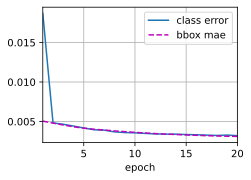

In [21]:
# 训练模型
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],
                       legend=['class error','bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)   
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)  
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds,cls_labels),cls_labels.numel(),
                  bbox_eval(bbox_preds,bbox_labels,bbox_masks),
                  bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
    
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on'
     f'{str(device)}')

In [22]:
# 预测目标
X = torchvision.io.read_image('01_Data/04_banana.jpg').unsqueeze(0).float()
img = X.squeeze(0).permute(1,2,0).long()

def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds,dim=2).permute(0,2,1) # softmax使得变成概率
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors) # 里面调用了NMS   
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx] # 只要置信度最大的框

output = predict(X)

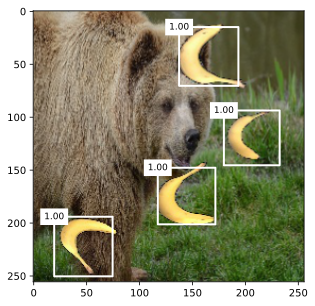

In [23]:
# 筛选所有置信度不低于0.9的边界框，做为最终输出
def display(img, output, threshold):
    d2l.set_figsize((5,5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes,bbox,'%.2f' % score,'w')
        
display(img,output.cpu(),threshold=0.9)

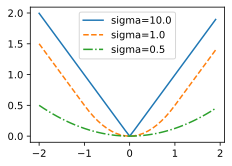

In [24]:
def smooth_11(data, scalar):
    out = []
    for i in data:
        if abs(i) < 1 / (scalar**2):
            out.append(((scalar * i)**2) / 2)
        else:
            out.append(abs(i) - 0.5 / (scalar**2))
    return torch.tensor(out)

sigmas = [10, 1, 0.5]
lines = ['-','--','-.']
x = torch.arange(-2,2,0.1)
d2l.set_figsize()

for l, s in zip(lines,sigmas):
    y = smooth_11(x,scalar=s)
    d2l.plt.plot(x,y,l,label='sigma=%.1f' % s)
    
d2l.plt.legend()

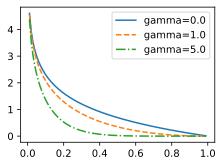

In [25]:
def focal_loss(gamma, x):
    return -(1 - x)**gamma * torch.log(x)

x = torch.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l, label='gamma=%.1f' % gamma)   

d2l.plt.legend()